<a href="https://colab.research.google.com/github/sushirito/ArsenicFR/blob/main/ArsenicAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# === Colab setup ===
# If in Colab, run this to mount Drive
from google.colab import drive  # safe if not in Colab
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install colour-science

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.9 MB/s eta 0:00:00


#Only One Training

[500] loss=3.1454e-01 rec=3.1386e-01 cal=6.8197e-04 rmean=2.2903e-03
[1000] loss=3.8857e-01 rec=3.8800e-01 cal=1.5391e-03 rmean=5.1552e-04
[1500] loss=1.7010e-01 rec=1.6975e-01 cal=8.6284e-04 rmean=4.3220e-04
[2000] loss=1.9207e-01 rec=1.9180e-01 cal=6.6399e-04 rmean=3.4052e-04
[2500] loss=3.8095e-01 rec=3.8080e-01 cal=3.3340e-04 rmean=2.4075e-04
[3000] loss=2.8169e-01 rec=2.8139e-01 cal=7.9735e-04 rmean=2.4832e-04
[3500] loss=2.0734e-01 rec=2.0643e-01 cal=2.7898e-03 rmean=3.3442e-04
[4000] loss=1.7944e-01 rec=1.7936e-01 cal=3.1947e-05 rmean=2.9041e-04
[4500] loss=2.0171e-01 rec=2.0146e-01 cal=5.2638e-04 rmean=4.1959e-04
[5000] loss=3.7726e-01 rec=3.7714e-01 cal=2.6849e-05 rmean=4.9980e-04
[5500] loss=2.1033e-01 rec=2.1025e-01 cal=1.9024e-05 rmean=3.7998e-04
[6000] loss=1.6554e-01 rec=1.6543e-01 cal=1.4555e-05 rmean=5.0724e-04
Best at step 1257  loss=9.0613e-02


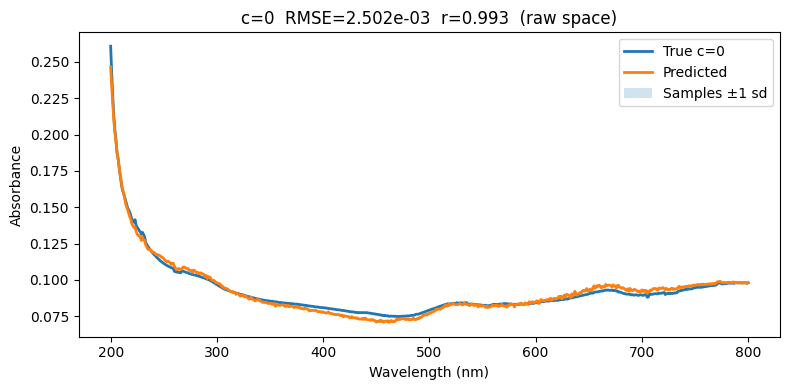

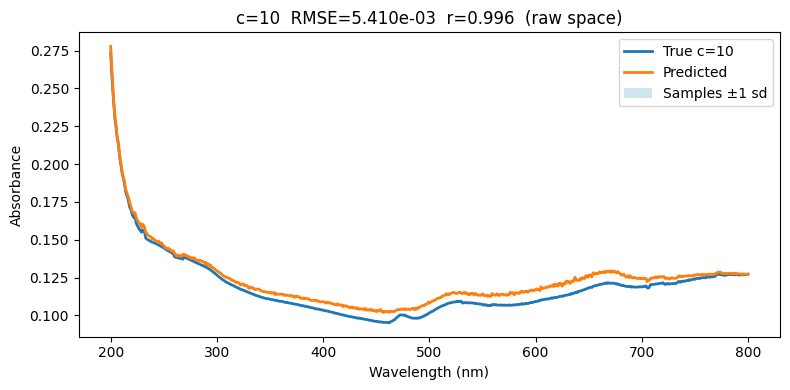

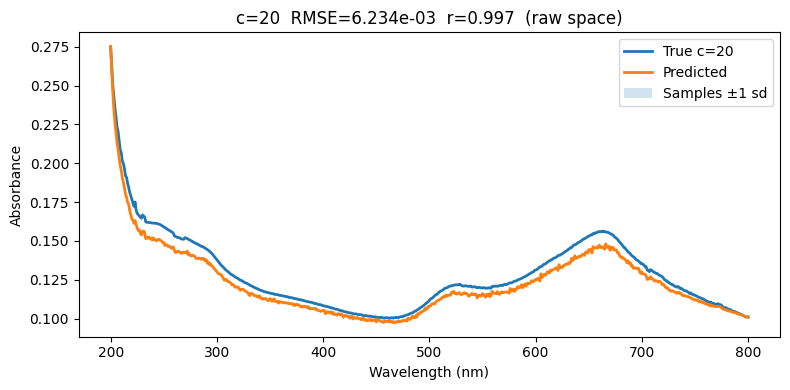

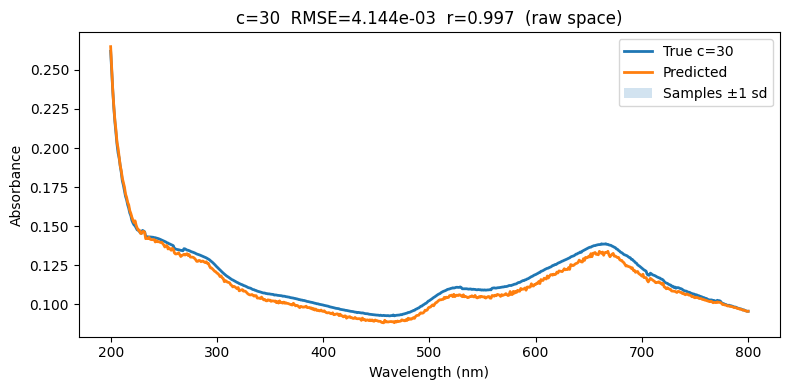

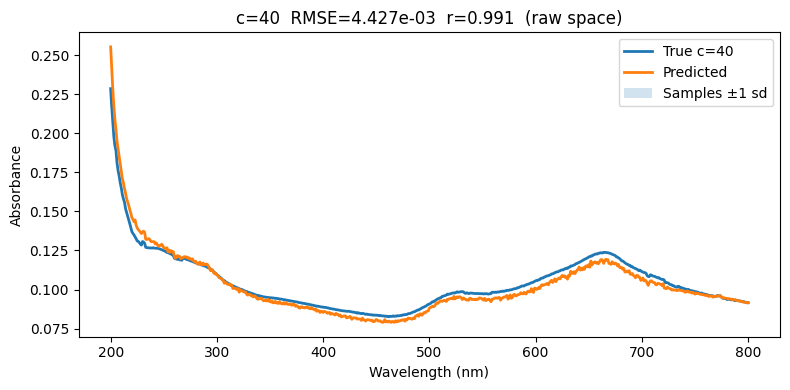

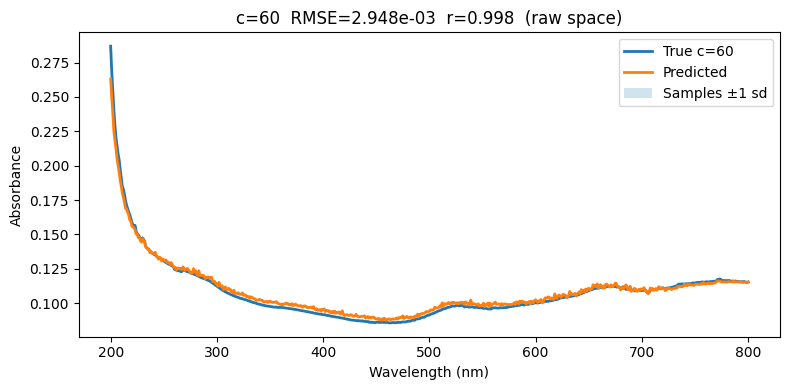

Saved CSV with raw true spectra + predictions to: /content/drive/MyDrive/ArsenicSTS/uvvis_predictions_raw.csv


In [4]:
# Optional pins
# !pip -q install torch torchvision torchaudio

import os, math, time, random, json, pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ------------------------------
# 0) Repro & device
# ------------------------------
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.set_float32_matmul_precision("medium")
except Exception:
    pass
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# 1) Paths
# ------------------------------
ROOT = "/content/drive/MyDrive/ArsenicSTS"
DATA_CSV = f"{ROOT}/UVVisData/0.30MB_AuNP_As.csv"
CKPT_DIR = f"{ROOT}/mean_residual_ckpt"
FIG_ROOT = f"{ROOT}/figs_mr"
os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(FIG_ROOT, exist_ok=True)

# ------------------------------
# 2) Data loader (unchanged logic)
# ------------------------------
def load_uvvis_csv(path, baseline_correct=True):
    df = pd.read_csv(path)
    df.columns = [str(c).strip() for c in df.columns]
    assert "Wavelength" in df.columns, "CSV must have 'Wavelength'"
    wl = df["Wavelength"].to_numpy().astype(np.float32)

    conc_cols = []
    for c in df.columns:
        if c == "Wavelength": continue
        try:
            float(c); conc_cols.append(c)
        except: pass

    conc_vals = np.array(sorted([float(c) for c in conc_cols], key=float), dtype=np.float32)
    conc_cols_sorted = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]
    A = np.stack([df[c].to_numpy().astype(np.float32) for c in conc_cols_sorted], axis=1)  # [λ, K]

    if baseline_correct:
        idx_800 = int(np.argmin(np.abs(wl - 800.0)))
        base = A[idx_800:idx_800+1, :]
        A = A - base
    return wl, conc_vals, A

# Training set (baseline-corrected)
wl, concs_all, A_bc = load_uvvis_csv(DATA_CSV, baseline_correct=True)
assert A_bc.shape[0] == 601 and A_bc.shape[1] == len(concs_all)

# Raw set for plotting and adding baseline back
wl_raw, concs_raw, A_raw = load_uvvis_csv(DATA_CSV, baseline_correct=False)
assert np.allclose(wl, wl_raw), "Wavelength grids differ; expected identical grids"

# ------------------------------
# 3) Helpers & scaler
# ------------------------------
C_MIN, C_MAX = float(concs_all.min()), float(concs_all.max())
def scale_c(c): return (c - C_MIN) / (C_MAX - C_MIN + 1e-12)

class SpectraScaler:
    def __init__(self): self.mean=None; self.std=None
    def fit(self, X):
        self.mean = X.mean(axis=0, keepdims=True)
        self.std = X.std(axis=0, keepdims=True) + 1e-6
    def transform(self, X): return (X - self.mean) / self.std
    def inverse(self, Xz): return Xz * self.std + self.mean
    def save(self, path):
        with open(path,"wb") as f: pickle.dump({"mean":self.mean,"std":self.std}, f)
    @staticmethod
    def load(path):
        with open(path,"rb") as f: d=pickle.load(f)
        sc=SpectraScaler(); sc.mean=d["mean"]; sc.std=d["std"]; return sc

# Fit scaler on baseline-corrected spectra (K columns)
X_real = A_bc.T.copy()                    # [K, 601] rows = concentrations
SCALER = SpectraScaler(); SCALER.fit(X_real)
Xz_real = SCALER.transform(X_real).astype(np.float32)  # [K, 601]

# ------------------------------
# 4) Mixup sampler (original)
# ------------------------------
def mixup_batch(batch_size=64, amp_noise=0.0, warp_nm=0.0):
    n = len(concs_all)
    i = np.random.randint(0, n, size=(batch_size,))
    j = np.random.randint(0, n, size=(batch_size,))
    a = np.random.beta(0.5, 0.5, size=(batch_size,1)).astype(np.float32)

    xi, xj = Xz_real[i], Xz_real[j]                        # z-scored
    ci, cj = concs_all[i].reshape(-1,1).astype(np.float32), concs_all[j].reshape(-1,1).astype(np.float32)

    x = a*xi + (1-a)*xj                                    # [B, 601]
    c = a*ci + (1-a)*cj                                    # [B, 1]

    if amp_noise > 0:
        x = x + np.random.normal(0.0, amp_noise, size=x.shape).astype(np.float32)

    if warp_nm > 0:
        step_nm = float(np.mean(np.diff(wl)))
        max_shift = int(np.floor(warp_nm / max(step_nm, 1e-12)))
        if max_shift >= 1:
            shifts = np.random.randint(-max_shift, max_shift + 1, size=(batch_size,))
            for b, s in enumerate(shifts):
                if s != 0: x[b] = np.roll(x[b], int(s))

    c01 = scale_c(c)
    xb = torch.from_numpy(x).to(DEVICE)
    cb = torch.from_numpy(c01).to(DEVICE)
    return xb, cb

# ------------------------------
# 5) Original architecture
# ------------------------------
class FiLMLayer(nn.Module):
    def __init__(self, cond_dim, hidden_dim):
        super().__init__()
        self.to_gamma = nn.Linear(cond_dim, hidden_dim)
        self.to_beta  = nn.Linear(cond_dim, hidden_dim)
    def forward(self, h, cond):
        gamma = self.to_gamma(cond)
        beta  = self.to_beta(cond)
        return h * (1 + gamma) + beta

class MeanNet(nn.Module):
    def __init__(self, c_dim=1, hidden=128, layers=3, out_dim=601):
        super().__init__()
        dims = [c_dim] + [hidden]*layers + [out_dim]
        f = []
        for i in range(len(dims)-2):
            f += [nn.Linear(dims[i], dims[i+1]), nn.SiLU(), nn.LayerNorm(dims[i+1])]
        f += [nn.Linear(dims[-2], dims[-1])]
        self.f = nn.Sequential(*f)
    def forward(self, c01): return self.f(c01)

class ResidualNet(nn.Module):
    def __init__(self, z_dim=4, c_dim=1, c_emb=32, hidden=256, layers=3, out_dim=601):
        super().__init__()
        self.c_embed = nn.Sequential(nn.Linear(c_dim, c_emb), nn.SiLU())
        self.inp = nn.Linear(z_dim, hidden)
        self.blocks = nn.ModuleList([nn.Sequential(nn.LayerNorm(hidden), nn.SiLU(), nn.Linear(hidden, hidden)) for _ in range(layers)])
        self.films  = nn.ModuleList([FiLMLayer(c_emb, hidden) for _ in range(layers)])
        self.out = nn.Linear(hidden, out_dim)
    def forward(self, z, c01):
        ce = self.c_embed(c01)
        h = self.inp(z)
        for blk, film in zip(self.blocks, self.films):
            h = blk(h); h = film(h, ce)
        return self.out(h)

class CalibHead(nn.Module):
    def __init__(self, in_dim=601):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(in_dim,256), nn.SiLU(),
            nn.Linear(256,64), nn.SiLU(),
            nn.Linear(64,1)
        )
    def forward(self, x): return self.f(x)

class MeanResidualModel(nn.Module):
    def __init__(self, z_dim=4):
        super().__init__()
        self.mean = MeanNet()
        self.res  = ResidualNet(z_dim=z_dim)
        self.cal  = CalibHead()
        self.z_dim = z_dim
    def forward_multi(self, c01, K=4):
        B = c01.size(0)
        mu = self.mean(c01)                                   # [B, 601]
        z  = torch.randn(B, K, self.z_dim, device=c01.device)
        c_rep = c01.unsqueeze(1).repeat(1, K, 1)              # [B, K, 1]
        r = self.res(z.view(B*K, -1), c_rep.view(B*K, -1))    # [B*K, 601]
        r = r.view(B, K, -1)
        r_mean = r.mean(dim=1)                                # [B, 601]
        x_mean = mu + r_mean
        return mu, r, r_mean, x_mean

# ------------------------------
# 6) Losses and training loop (original)
# ------------------------------
def second_deriv_loss(x, strength=1.0):
    d2 = x[:, 2:] - 2*x[:, 1:-1] + x[:, :-2]
    return strength * (d2.pow(2).mean())

def train_mean_residual(steps=6000, batch_size=64, K=6, lr=5e-4,
                        w_rec=1.0, w_rmean=0.2, w_cal=0.3, w_smooth=1e-3,
                        amp_noise=0.002, warp_nm=1.0, ckpt_dir=CKPT_DIR):
    model = MeanResidualModel(z_dim=4).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=steps, eta_min=1e-5)
    best = {"loss": 1e9, "step": 0}

    for step in range(1, steps+1):
        xb, cb = mixup_batch(batch_size=batch_size, amp_noise=amp_noise, warp_nm=warp_nm)  # xb z-scored
        mu, r_all, r_mean, x_mean = model.forward_multi(cb, K=K)

        rec = F.mse_loss(x_mean, xb)                      # reconstruction
        rmean = r_mean.pow(2).mean()                      # mean residual to zero
        cal = F.mse_loss(model.cal(x_mean), cb)           # predict c from spectrum
        smooth = second_deriv_loss(mu)                    # smooth μ(c)
        loss = w_rec*rec + w_rmean*rmean + w_cal*cal + w_smooth*smooth

        opt.zero_grad(set_to_none=True)
        loss.backward(); opt.step(); sch.step()

        if loss.item() < best["loss"] - 1e-6:
            best = {"loss": float(loss.item()), "step": step}
            torch.save(model.state_dict(), os.path.join(ckpt_dir, "mr_model.pt"))
            SCALER.save(os.path.join(ckpt_dir, "scaler.pkl"))

        if step % 500 == 0:
            print(f"[{step}] loss={loss.item():.4e} rec={rec.item():.4e} cal={cal.item():.4e} rmean={rmean.item():.4e}")

    print(f"Best at step {best['step']}  loss={best['loss']:.4e}")
    return model

def load_model(ckpt_dir=CKPT_DIR):
    m = MeanResidualModel(z_dim=4).to(DEVICE)
    m.load_state_dict(torch.load(os.path.join(ckpt_dir, "mr_model.pt"), map_location=DEVICE))
    sc = SpectraScaler.load(os.path.join(ckpt_dir, "scaler.pkl"))
    m.eval()
    return m, sc

# ------------------------------
# 7) Inference helpers (original + baseline add-back for raw plotting)
# ------------------------------
@torch.no_grad()
def predict_mean_spectrum(model, scaler, c_target):
    c01 = torch.tensor([[scale_c(float(c_target))]], device=DEVICE).float()
    mu = model.mean(c01)[0].cpu().numpy()                 # z-scored
    x_bc = scaler.inverse(mu[None, :])[0]                 # baseline-corrected prediction
    return x_bc                                           # length 601

@torch.no_grad()
def sample_spectra(model, scaler, c_target, N=64):
    c01 = torch.full((N,1), fill_value=scale_c(float(c_target)), device=DEVICE).float()
    mu, r, r_mean, x_mean = model.forward_multi(c01, K=1)
    xhat = mu + r_mean
    x_bc = scaler.inverse(xhat.cpu().numpy())
    return x_bc

# ------------------------------
# 8) Train once, then plot raw-space truth vs prediction
# ------------------------------
model = train_mean_residual(
    steps=6000, batch_size=64, K=6, lr=5e-4,
    w_rec=1.0, w_rmean=0.2, w_cal=0.3, w_smooth=1e-3,
    amp_noise=0.002, warp_nm=1.0, ckpt_dir=CKPT_DIR
)
model, SCALER = load_model(CKPT_DIR)

# Long-format rows for CSV
out_rows = []

# Precompute index of 800 nm
idx_800 = int(np.argmin(np.abs(wl - 800.0)))

# Per-concentration plots: raw true vs predicted-with-baseline
for c_val in concs_all:
    # baseline-corrected pred
    x_pred_bc = predict_mean_spectrum(model, SCALER, float(c_val))   # length 601

    # add back raw baseline at 800 nm for this concentration
    conc_idx = int(np.where(concs_raw == c_val)[0][0])
    base_true = A_raw[idx_800, conc_idx]
    x_pred_raw = x_pred_bc + base_true

    # raw true
    x_true_raw = A_raw[:, conc_idx]

    # metrics
    rmse = float(np.sqrt(np.mean((x_true_raw - x_pred_raw)**2)))
    r = float(np.corrcoef(x_true_raw, x_pred_raw)[0,1])

    # plot in raw space
    plt.figure(figsize=(8,4))
    plt.plot(wl, x_true_raw, label=f"True c={int(c_val)}", lw=2)
    plt.plot(wl, x_pred_raw, label="Predicted", lw=2)
    # optional uncertainty band from samples (converted to raw by adding base_true)
    Xs_bc = sample_spectra(model, SCALER, float(c_val), N=128)
    m_bc, s_bc = Xs_bc.mean(axis=0), Xs_bc.std(axis=0)
    plt.fill_between(wl, m_bc+base_true - s_bc, m_bc+base_true + s_bc, alpha=0.2, label="Samples ±1 sd")
    plt.xlabel("Wavelength (nm)"); plt.ylabel("Absorbance")
    plt.title(f"c={int(c_val)}  RMSE={rmse:.3e}  r={r:.3f}  (raw space)")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(FIG_ROOT, f"pred_vs_true_raw_c_{int(c_val)}.png"), dpi=160)
    plt.show()

    # accumulate long-format CSV rows
    for w, t, p in zip(wl, x_true_raw, x_pred_raw):
        out_rows.append({
            "Wavelength": float(w),
            "Concentration": float(c_val),
            "Absorbance_True": float(t),
            "Absorbance_Pred": float(p),
        })

# ------------------------------
# 9) Save long-format CSV for downstream color work
# ------------------------------
df_out = pd.DataFrame(out_rows)
out_csv = os.path.join(ROOT, "uvvis_predictions_raw.csv")
df_out.to_csv(out_csv, index=False)
print("Saved CSV with raw true spectra + predictions to:", out_csv)


#Uncertainty

== Train member 0 in /content/drive/MyDrive/ArsenicSTS/mean_residual_ckpt/ens_0
[500] loss=-7.6578e-01 nll=-7.6697e-01 cal=3.5114e-04 rmean=5.1731e-03 sreg=3.394e+00
[1000] loss=-4.8183e-01 nll=-4.8280e-01 cal=2.0162e-03 rmean=1.5966e-03 sreg=3.757e+00
[1500] loss=-8.0405e-01 nll=-8.0440e-01 cal=1.0660e-04 rmean=1.3588e-03 sreg=3.669e+00
[2000] loss=-4.3116e-01 nll=-4.3143e-01 cal=2.3335e-04 rmean=7.7642e-04 sreg=3.905e+00
[2500] loss=-4.2824e-01 nll=-4.2842e-01 cal=5.8312e-05 rmean=6.3484e-04 sreg=3.488e+00
[3000] loss=-2.2677e-01 nll=-2.2700e-01 cal=2.0341e-04 rmean=6.4403e-04 sreg=3.642e+00
[3500] loss=-6.9938e-01 nll=-6.9957e-01 cal=6.1184e-05 rmean=6.7825e-04 sreg=3.449e+00
[4000] loss=-7.4930e-01 nll=-7.4945e-01 cal=5.2133e-05 rmean=4.7610e-04 sreg=3.168e+00
[4500] loss=-6.7289e-01 nll=-6.7301e-01 cal=6.2146e-05 rmean=3.4550e-04 sreg=3.008e+00
[5000] loss=-6.5741e-01 nll=-6.5756e-01 cal=6.9390e-05 rmean=4.8120e-04 sreg=3.292e+00
Best at step 1143  loss=-1.2382e+00
== Train member

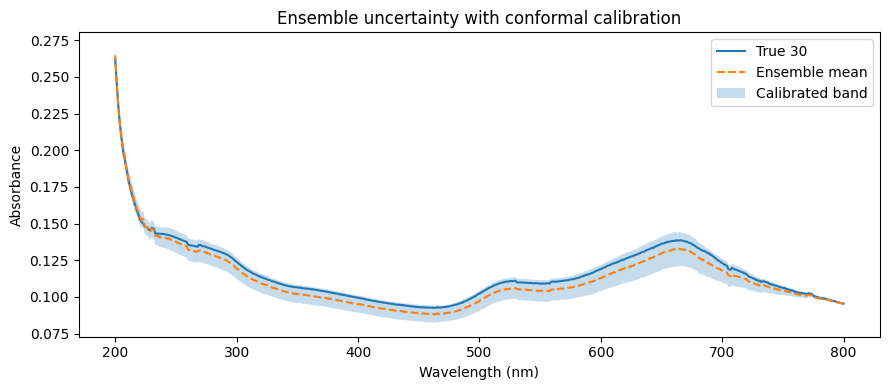

In [7]:
# =========================
# Full-uncertainty extension
# =========================
# Requirements: wl, concs_all, A_raw, SCALER, mixup_batch(), MeanResidualModel as in your code.
# This adds:
#  - VarNet that predicts per-wavelength log-variance in z-space
#  - NLL training
#  - Ensemble training and loading
#  - Variance decomposition (within + predicted + between)
#  - Split conformal calibration -> calibrated ± bands

import os, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from copy import deepcopy
EPS = 1e-8

# -------- 1) Variance head --------
class VarNet(nn.Module):
    def __init__(self, c_dim=1, hidden=128, layers=3, out_dim=601):
        super().__init__()
        dims = [c_dim] + [hidden]*layers + [out_dim]
        f = []
        for i in range(len(dims)-2):
            f += [nn.Linear(dims[i], dims[i+1]), nn.SiLU(), nn.LayerNorm(dims[i+1])]
        f += [nn.Linear(dims[-2], dims[-1])]
        self.f = nn.Sequential(*f)
    def forward(self, c01):  # returns log-variance s (z-space)
        return self.f(c01)

# -------- 2) Model with heteroscedastic head --------
class MeanResidualHetero(nn.Module):
    def __init__(self, z_dim=4):
        super().__init__()
        self.core = MeanResidualModel(z_dim=z_dim)  # your existing mean+res+cal
        self.var  = VarNet()                        # predicts s (log σ²) in z-space
    def forward_multi(self, c01, K=4):
        return self.core.forward_multi(c01, K=K)
    def logvar(self, c01):
        return self.var(c01)

# -------- 3) Training with Gaussian NLL --------
def gaussian_nll(x_target_z, x_mean_z, s_logvar):
    # all in z-space
    return ((x_target_z - x_mean_z)**2 * torch.exp(-s_logvar) + s_logvar).mean()

def train_hetero_model(
    steps=6000, batch_size=64, K=6, lr=5e-4,
    w_nll=1.0, w_rmean=0.2, w_cal=0.3, w_smooth=1e-3, w_sreg=1e-5,
    amp_noise=0.002, warp_nm=1.0, ckpt_dir=CKPT_DIR, seed=1337
):
    g = torch.Generator(device=DEVICE); g.manual_seed(seed)
    torch.manual_seed(seed); np.random.seed(seed)
    model = MeanResidualHetero(z_dim=4).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=steps, eta_min=1e-5)
    best = {"loss": 1e9, "step": 0}

    for step in range(1, steps+1):
        xb, cb = mixup_batch(batch_size=batch_size, amp_noise=amp_noise, warp_nm=warp_nm)  # xb is z-scored
        mu, r_all, r_mean, x_mean = model.forward_multi(cb, K=K)  # z-space
        s_logvar = model.logvar(cb)                                # z-space

        # losses
        nll   = gaussian_nll(xb, x_mean, s_logvar)
        rmean = r_mean.pow(2).mean()
        cal   = F.mse_loss(model.core.cal(x_mean), cb)
        # smooth the mean-only path for stability
        smooth = second_deriv_loss(mu)
        # tiny regularizer to keep logvar bounded
        sreg  = (s_logvar**2).mean()

        loss = w_nll*nll + w_rmean*rmean + w_cal*cal + w_smooth*smooth + w_sreg*sreg

        opt.zero_grad(set_to_none=True)
        loss.backward(); opt.step(); sch.step()

        if loss.item() < best["loss"] - 1e-7:
            best = {"loss": float(loss.item()), "step": step}
            torch.save(model.state_dict(), os.path.join(ckpt_dir, "mr_hetero.pt"))
            SCALER.save(os.path.join(ckpt_dir, "scaler.pkl"))

        if step % 500 == 0:
            print(f"[{step}] loss={loss.item():.4e} nll={nll.item():.4e} cal={cal.item():.4e} rmean={rmean.item():.4e} sreg={sreg.item():.3e}")

    print(f"Best at step {best['step']}  loss={best['loss']:.4e}")
    return model

def load_hetero_model(ckpt_dir=CKPT_DIR):
    m = MeanResidualHetero(z_dim=4).to(DEVICE)
    m.load_state_dict(torch.load(os.path.join(ckpt_dir, "mr_hetero.pt"), map_location=DEVICE))
    sc = SpectraScaler.load(os.path.join(ckpt_dir, "scaler.pkl"))
    m.eval()
    return m, sc

# -------- 4) Ensemble training and loading --------
def train_ensemble(M=5, base_ckpt_dir=CKPT_DIR, start_seed=1000, **kwargs):
    ckpts = []
    for i in range(M):
        sub = os.path.join(base_ckpt_dir, f"ens_{i}")
        os.makedirs(sub, exist_ok=True)
        print(f"== Train member {i} in {sub}")
        train_hetero_model(ckpt_dir=sub, seed=start_seed+i, **kwargs)
        ckpts.append(sub)
    return ckpts

def load_ensemble(ckpt_dirs):
    members = []
    for sub in ckpt_dirs:
        m, sc = load_hetero_model(sub)
        members.append((m, sc))
    return members

# -------- 5) Per-model stats in RAW space with variance decomposition --------
idx_800 = int(np.argmin(np.abs(wl - 800.0)))

@torch.no_grad()
def model_stats_raw(member, c_val: float, N_latent: int = 128):
    m, sc = member
    c01 = torch.full((N_latent,1), fill_value=scale_c(float(c_val)), device=DEVICE).float()
    # latent sampling -> baseline-corrected in RAW units
    mu, r, r_mean, x_mean = m.forward_multi(c01, K=1)   # z-space
    X_bc = sc.inverse((mu + r_mean).cpu().numpy())      # [N, 601] raw baseline-corrected
    # add baseline interpolation at 800 nm
    baseline_curve = A_raw[idx_800, :]
    base = np.interp(float(c_val), concs_all, baseline_curve)
    X_raw = X_bc + base

    # per-wavelength stats
    mu_raw = X_raw.mean(axis=0)                         # [601]
    within_var_raw = X_raw.var(axis=0, ddof=0)          # from latent sampling

    # predicted logvar is in z-space for a single c
    c01_single = torch.tensor([[scale_c(float(c_val))]], device=DEVICE).float()
    s_logvar = m.logvar(c01_single)[0].cpu().numpy()    # [601]
    # convert predicted var from z to raw: multiply by (std^2)
    std_raw = sc.std[0]                                  # [601]
    pred_var_raw = np.exp(s_logvar) * (std_raw**2)

    return mu_raw, within_var_raw, pred_var_raw

def ensemble_stats_raw(ensemble, c_val: float, N_latent: int = 128):
    mu_list, within_list, pred_list = [], [], []
    for member in ensemble:
        mu_raw, within_var_raw, pred_var_raw = model_stats_raw(member, c_val, N_latent)
        mu_list.append(mu_raw); within_list.append(within_var_raw); pred_list.append(pred_var_raw)
    mu_list = np.stack(mu_list, 0)          # [M, 601]
    within_list = np.stack(within_list, 0)  # [M, 601]
    pred_list = np.stack(pred_list, 0)      # [M, 601]

    mu_ens = mu_list.mean(axis=0)
    var_between = mu_list.var(axis=0, ddof=0)
    var_within_pred = (within_list + pred_list).mean(axis=0)
    var_total = var_between + var_within_pred
    return mu_ens, var_total, var_between, var_within_pred

# -------- 6) Split conformal calibration on ensemble variance --------
def true_raw_at_conc(c_val: float):
    j = int(np.where(concs_all == c_val)[0][0])
    return A_raw[:, j].astype(float)

def calibrate_k_ensemble(ensemble, cal_concs, alpha=0.10, N_latent=256):
    zs = []
    for c in cal_concs:
        y = true_raw_at_conc(float(c))
        mu, var_total, _, _ = ensemble_stats_raw(ensemble, float(c), N_latent=N_latent)
        s = np.sqrt(np.maximum(var_total, EPS))
        z = np.abs(y - mu) / (s + EPS)
        zs.append(z)
    zs = np.concatenate(zs, axis=0)
    k = float(np.quantile(zs, 1.0 - alpha))
    return k

def predict_with_band_ensemble(ensemble, c_val: float, k: float, N_latent: int = 256):
    mu, var_total, var_between, var_within_pred = ensemble_stats_raw(ensemble, float(c_val), N_latent=N_latent)
    s = np.sqrt(np.maximum(var_total, EPS))
    lo, hi = mu - k*s, mu + k*s
    return wl.astype(float), mu, lo, hi, var_between, var_within_pred

def eval_coverage_ensemble(ensemble, test_concs, k: float, N_latent: int = 256):
    covs = []
    for c in test_concs:
        y = true_raw_at_conc(float(c))
        _, mu, lo, hi, _, _ = predict_with_band_ensemble(ensemble, float(c), k, N_latent)
        inside = ((y >= lo) & (y <= hi)).mean()
        covs.append((float(c), float(inside)))
    return covs

# -------- 7) Example usage --------
# 1) Train ensemble
ens_dirs = train_ensemble(
    M=5, base_ckpt_dir=CKPT_DIR, start_seed=2025,
    steps=5000, batch_size=64, K=6, lr=5e-4,
    w_nll=1.0, w_rmean=0.2, w_cal=0.3, w_smooth=1e-3, w_sreg=1e-5,
    amp_noise=0.002, warp_nm=1.0
)

# 2) Load ensemble
ensemble = load_ensemble(ens_dirs)

# 3) Calibrate k on held concentrations (recommend LOCO or at least leave 1-2 out)
CAL_CONCS  = [20.0, 40.0]
TEST_CONCS = [0.0, 10.0, 30.0, 60.0]
k90 = calibrate_k_ensemble(ensemble, CAL_CONCS, alpha=0.10, N_latent=512)
print("k for 90% nominal:", k90)
print("Empirical wavelength-wise coverage:")
for c, cov in eval_coverage_ensemble(ensemble, TEST_CONCS, k90, N_latent=512):
    print(f"  c={int(c)}  coverage≈{cov:.3f}")

# 4) Plot one example band
import matplotlib.pyplot as plt
c_example = 30.0
w, mu, lo, hi, v_between, v_within_pred = predict_with_band_ensemble(ensemble, c_example, k90, N_latent=512)
y = true_raw_at_conc(c_example)
plt.figure(figsize=(9,4))
plt.plot(w, y, label=f"True {int(c_example)}")
plt.plot(w, mu, "--", label="Ensemble mean")
plt.fill_between(w, lo, hi, alpha=0.25, label="Calibrated band")
plt.xlabel("Wavelength (nm)"); plt.ylabel("Absorbance")
plt.title("Ensemble uncertainty with conformal calibration")
plt.legend(); plt.tight_layout(); plt.show()


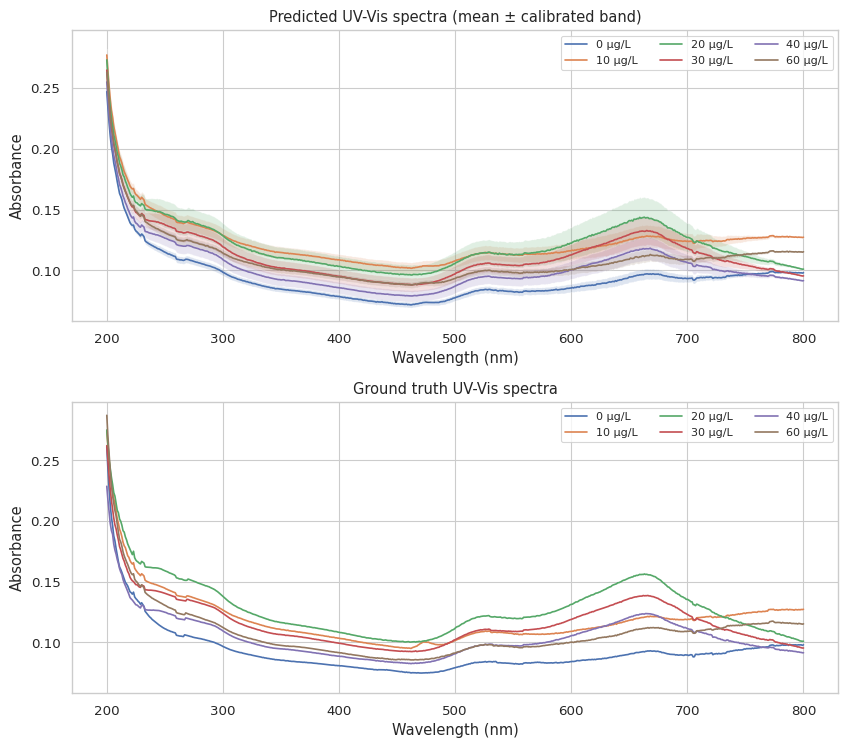

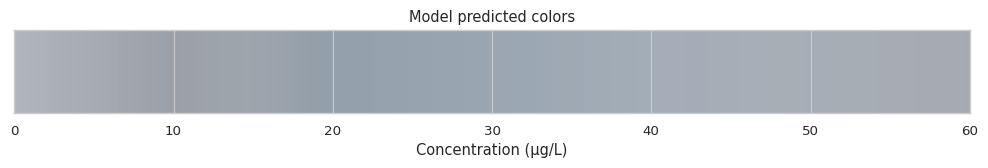

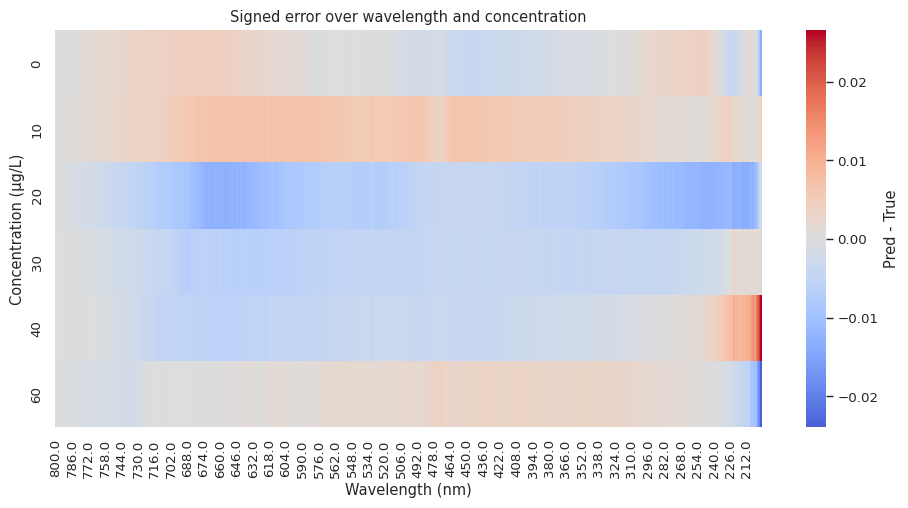

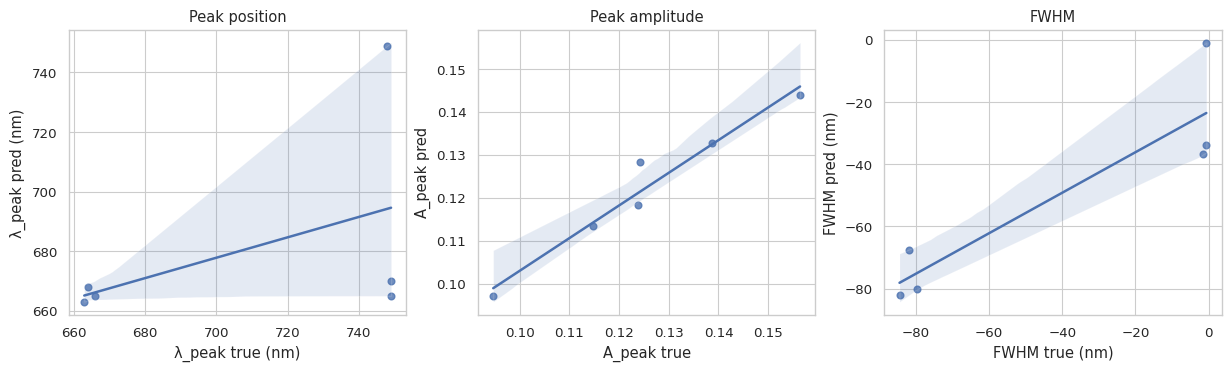

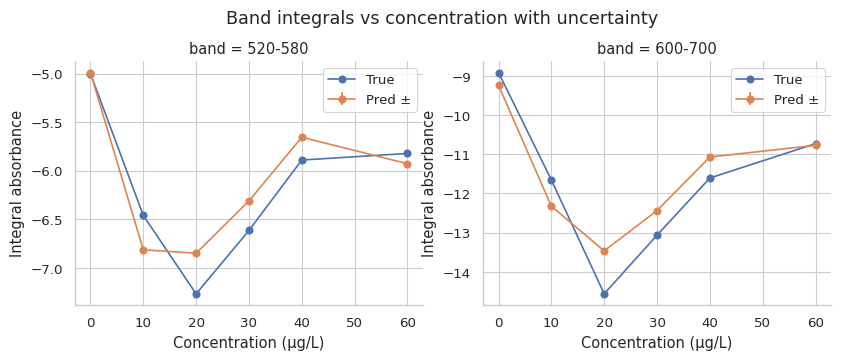

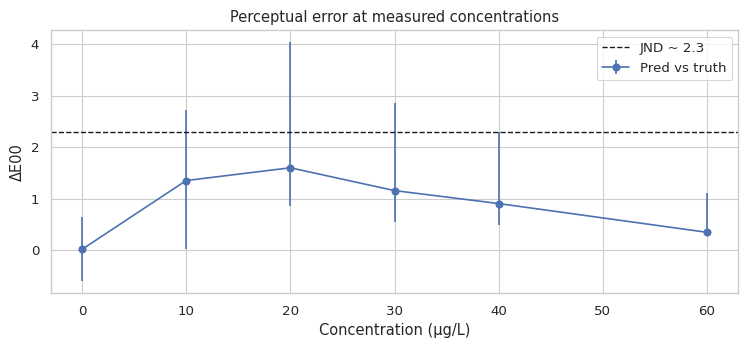

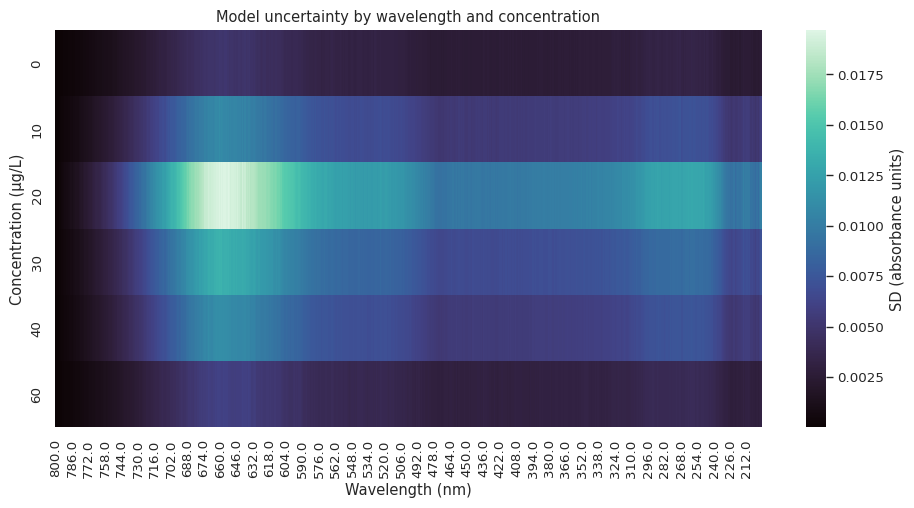

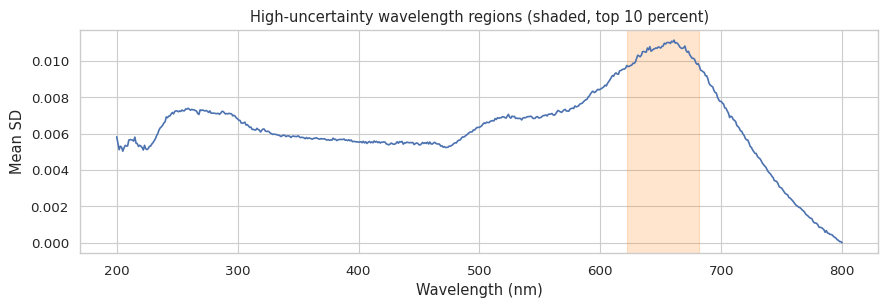

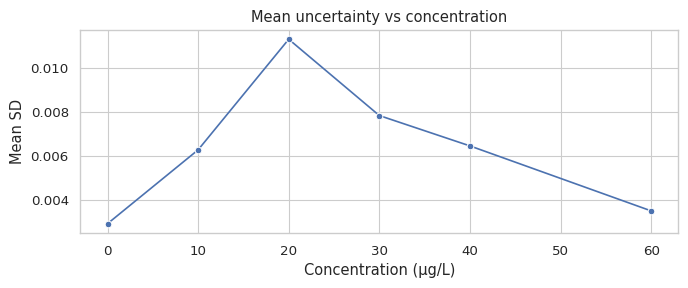

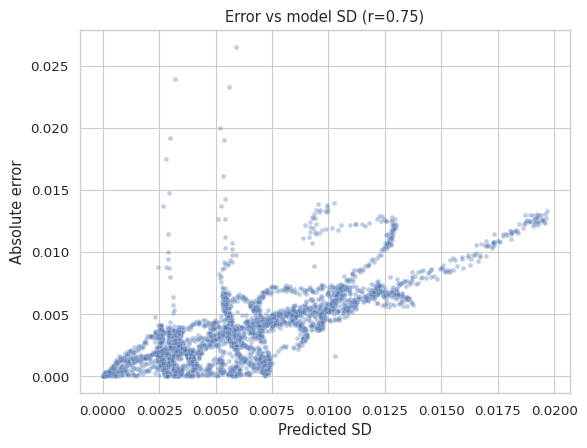

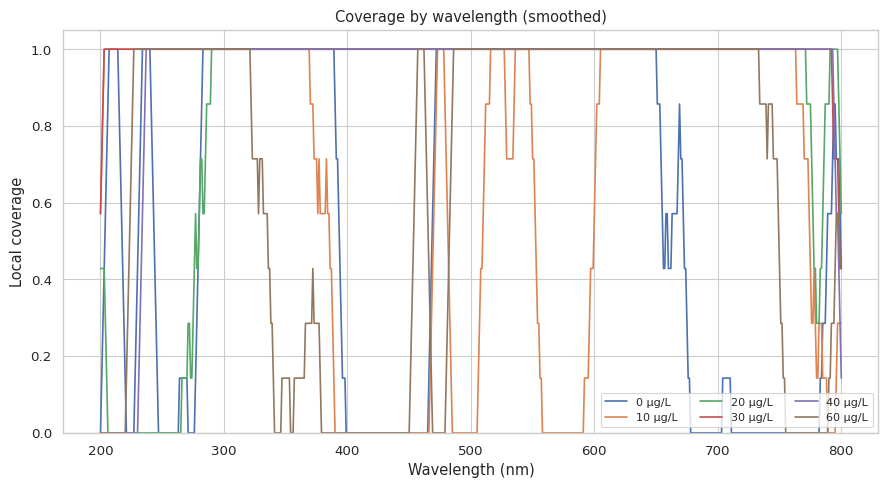

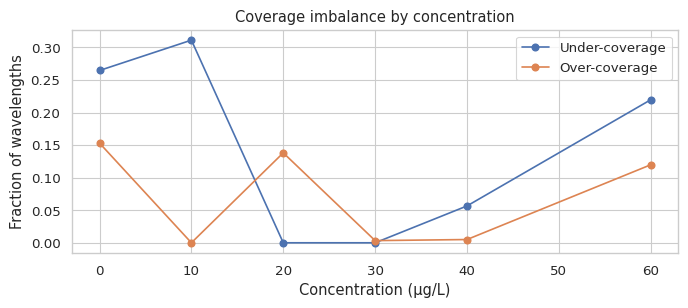

Saved summary with uncertainty: /content/drive/MyDrive/ArsenicSTS/summary_metrics_with_uncertainty.csv


In [12]:
# === Re-plot suite with per-wavelength ± bands and uncertainty-focused views ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.signal import find_peaks, peak_widths
from numpy import trapezoid
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB, XYZ_to_Lab
from colour.difference import delta_E as deltaE
from colour import MSDS_CMFS, SDS_ILLUMINANTS

sns.set_theme(style="whitegrid", context="paper", font_scale=1.1)
os.makedirs(FIG_ROOT, exist_ok=True)
SAVE = True

# ---------- helpers ----------
def rmse(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.mean((a - b)**2)))

def pearson_r(a, b):
    a = np.asarray(a); b = np.asarray(b)
    if a.std() == 0 or b.std() == 0: return 0.0
    return float(np.corrcoef(a, b)[0,1])

# Robust ΔE00 that always returns a scalar
def dE00(Lab1, Lab2):
    v = deltaE(np.array(Lab1, ndmin=2), np.array(Lab2, ndmin=2), method="CIE 2000")
    return float(np.asarray(v).ravel()[0])

# Robust peak metrics using peak_widths at half height
def peak_metrics(wl, A, window=(520, 750)):
    sel = (wl >= window[0]) & (wl <= window[1])
    w, y = wl[sel], A[sel]
    if y.size < 5: return np.nan, np.nan, np.nan
    peaks, _ = find_peaks(y)
    if peaks.size == 0:
        i = int(np.argmax(y))
    else:
        i = peaks[np.argmax(y[peaks])]
    lam_peak, A_peak = float(w[i]), float(y[i])
    try:
        widths, _, _, _ = peak_widths(y, [i], rel_height=0.5)
        nm_per_sample = float(np.mean(np.diff(w)))
        fwhm_nm = float(widths[0] * nm_per_sample)
    except Exception:
        fwhm_nm = np.nan
    return lam_peak, A_peak, fwhm_nm

cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']
ABS_MULT = 4.0

def spectra_to_Lab(wavelengths, absorbance):
    vis = (wavelengths >= 380) & (wavelengths <= 780)
    w = wavelengths[vis]; A = absorbance[vis]
    T = 10 ** (-ABS_MULT * A)
    sd = SpectralDistribution(dict(zip(w, T)))
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100.0
    return XYZ_to_Lab(XYZ, illuminant=illuminant)

def spectra_to_rgb(wavelengths, absorbance):
    vis = (wavelengths >= 380) & (wavelengths <= 780)
    w = wavelengths[vis]; A = absorbance[vis]
    T = 10 ** (-ABS_MULT * A)
    sd = SpectralDistribution(dict(zip(w, T)))
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100.0
    rgb = np.clip(XYZ_to_sRGB(XYZ), 0, 1)
    return rgb

def get_mu_band_at_c(ensemble, k, c_val, N_latent=512):
    w, mu, lo, hi, v_between, v_within_pred = predict_with_band_ensemble(
        ensemble, float(c_val), k, N_latent=N_latent
    )
    s_tot = np.sqrt(np.maximum(v_between + v_within_pred, 1e-12))  # pre-scale SD
    return w, mu, lo, hi, s_tot

# Ensure k90 exists
if 'k90' not in globals():
    cal_pool = [c for c in [20.0, 40.0, 30.0] if float(c) in set(concs_all.astype(float))]
    if not cal_pool: cal_pool = [float(concs_all[len(concs_all)//2])]
    k90 = calibrate_k_ensemble(ensemble, cal_pool, alpha=0.10, N_latent=512)

# ---------- Fig 1: Predicted vs Ground Truth with bands ----------
plt.figure(figsize=(8.6, 7.6))
ax1 = plt.subplot(2,1,1)
for c in concs_all:
    w, mu, lo, hi, _ = get_mu_band_at_c(ensemble, k90, float(c))
    sns.lineplot(x=w, y=mu, label=f"{int(c)} µg/L", ax=ax1)
    ax1.fill_between(w, lo, hi, alpha=0.18)
ax1.set_title("Predicted UV-Vis spectra (mean ± calibrated band)")
ax1.set_xlabel("Wavelength (nm)"); ax1.set_ylabel("Absorbance")
ax1.legend(ncol=3, fontsize=8)

ax2 = plt.subplot(2,1,2, sharex=ax1, sharey=ax1)
for c in concs_all:
    y = true_raw_at_conc(float(c))
    sns.lineplot(x=wl, y=y, label=f"{int(c)} µg/L", ax=ax2)
ax2.set_title("Ground truth UV-Vis spectra")
ax2.set_xlabel("Wavelength (nm)"); ax2.set_ylabel("Absorbance")
ax2.legend(ncol=3, fontsize=8)
plt.tight_layout()
if SAVE: plt.savefig(os.path.join(FIG_ROOT, "fig1_pred_vs_truth.png"), dpi=300)
plt.show()

# ---------- Fig 2: Model-only color gradient ----------
c_grid = np.round(np.linspace(float(concs_all.min()), float(concs_all.max()), 121), 6)
rgb_bar = []
for c in c_grid:
    _, mu, _, _, _ = get_mu_band_at_c(ensemble, k90, c)
    rgb_bar.append(spectra_to_rgb(wl, mu))
rgb_bar = np.array(rgb_bar)
fig, ax = plt.subplots(1, 1, figsize=(10, 1.8))
ax.imshow(rgb_bar[np.newaxis, :, :], aspect='auto', extent=[c_grid[0], c_grid[-1], 0, 1])
ax.set_title("Model predicted colors"); ax.set_yticks([]); ax.set_xlabel("Concentration (µg/L)")
plt.tight_layout()
if SAVE: plt.savefig(os.path.join(FIG_ROOT, "fig2_color_gradient_model.png"), dpi=300)
plt.show()

# ---------- Fig 3: Signed error heatmap ----------
err_mat = []
for c in concs_all:
    y_true = true_raw_at_conc(float(c))
    _, mu, _, _, _ = get_mu_band_at_c(ensemble, k90, float(c))
    err_mat.append(mu - y_true)
err_mat = np.stack(err_mat, axis=1)  # [λ, K]
df_err = pd.DataFrame(err_mat, index=wl, columns=[int(c) for c in concs_all])
plt.figure(figsize=(9.6, 5.2))
sns.heatmap(df_err.T, cmap="coolwarm", center=0, cbar_kws={"label": "Pred - True"})
plt.xlabel("Wavelength (nm)"); plt.ylabel("Concentration (µg/L)")
plt.title("Signed error over wavelength and concentration")
plt.tight_layout()
if SAVE: plt.savefig(os.path.join(FIG_ROOT, "fig3_error_heatmap.png"), dpi=300)
plt.show()

# ---------- Fig 4: Peak metrics agreement (robust FWHM) ----------
rows = []
for c in concs_all:
    y_true = true_raw_at_conc(float(c))
    _, mu, _, _, _ = get_mu_band_at_c(ensemble, k90, float(c))
    t_lp, t_ap, t_fw = peak_metrics(wl, y_true)
    p_lp, p_ap, p_fw = peak_metrics(wl, mu)
    rows.append({"c": float(c),
                 "lam_true": t_lp, "A_true": t_ap, "FWHM_true": t_fw,
                 "lam_pred": p_lp, "A_pred": p_ap, "FWHM_pred": p_fw})
df_pk = pd.DataFrame(rows)

fig, axs = plt.subplots(1,3, figsize=(12.2,3.6), constrained_layout=True)
sns.regplot(data=df_pk.dropna(subset=["lam_true","lam_pred"]),
            x="lam_true", y="lam_pred", ax=axs[0])
axs[0].set_xlabel("λ_peak true (nm)"); axs[0].set_ylabel("λ_peak pred (nm)"); axs[0].set_title("Peak position")

sns.regplot(data=df_pk.dropna(subset=["A_true","A_pred"]),
            x="A_true", y="A_pred", ax=axs[1])
axs[1].set_xlabel("A_peak true"); axs[1].set_ylabel("A_peak pred"); axs[1].set_title("Peak amplitude")

sns.regplot(data=df_pk.dropna(subset=["FWHM_true","FWHM_pred"]),
            x="FWHM_true", y="FWHM_pred", ax=axs[2])
axs[2].set_xlabel("FWHM true (nm)"); axs[2].set_ylabel("FWHM pred (nm)"); axs[2].set_title("FWHM")
if SAVE: plt.savefig(os.path.join(FIG_ROOT, "fig4_peak_metrics_scatter.png"), dpi=300)
plt.show()

# ---------- Fig 5: Band integrals vs concentration with uncertainty ----------
bands = [(520, 580), (600, 700)]
rows = []
for c in concs_all:
    y_true = true_raw_at_conc(float(c))
    w, mu, lo, hi, _ = get_mu_band_at_c(ensemble, k90, float(c))
    for b0, b1 in bands:
        sel = (w >= b0) & (w <= b1)
        It  = float(trapezoid(y_true[sel], w[sel]))
        Im  = float(trapezoid(mu[sel],     w[sel]))
        Ihi = float(trapezoid(hi[sel],     w[sel]))
        Ilo = float(trapezoid(lo[sel],     w[sel]))
        I_minus = max(0.0, Im - Ilo)
        I_plus  = max(0.0, Ihi - Im)
        rows.append({"c": float(c), "band": f"{b0}-{b1}",
                     "I_true": It, "I_mu": Im, "I_minus": I_minus, "I_plus": I_plus})
df_b = pd.DataFrame(rows)

g = sns.FacetGrid(df_b, col="band", sharey=False, height=3.2, aspect=1.3)
for ax, (band, sub) in zip(g.axes.flat, df_b.groupby("band", sort=False)):
    sub = sub.sort_values("c")
    ax.plot(sub["c"], sub["I_true"], marker="o", label="True")
    yerr = np.vstack([sub["I_minus"].to_numpy(), sub["I_plus"].to_numpy()])
    ax.errorbar(sub["c"], sub["I_mu"], yerr=yerr, fmt="-o", label="Pred ±")
    ax.set_xlabel("Concentration (µg/L)"); ax.set_ylabel("Integral absorbance"); ax.legend()
g.fig.suptitle("Band integrals vs concentration with uncertainty", y=1.05)
if SAVE: g.fig.savefig(os.path.join(FIG_ROOT, "fig5_band_integrals.png"), dpi=300, bbox_inches="tight")
plt.show()

# ---------- Fig 6: Perceptual error across concentration (with whiskers) ----------
de_rows = []
for c in concs_all:
    y_true = true_raw_at_conc(float(c))
    _, mu, lo, hi, _ = get_mu_band_at_c(ensemble, k90, float(c))
    Lab_t  = spectra_to_Lab(wl, y_true)
    Lab_mu = spectra_to_Lab(wl, mu)
    Lab_lo = spectra_to_Lab(wl, lo)
    Lab_hi = spectra_to_Lab(wl, hi)
    d_mu = dE00(Lab_t, Lab_mu)
    d_lo = dE00(Lab_t, Lab_lo)
    d_hi = dE00(Lab_t, Lab_hi)
    lo_err = abs(d_mu - min(d_lo, d_hi))
    hi_err = abs(max(d_lo, d_hi) - d_mu)
    de_rows.append({"c": float(c), "dE00": d_mu, "dE_minus": lo_err, "dE_plus": hi_err})
df_de = pd.DataFrame(de_rows).sort_values("c")
plt.figure(figsize=(7.6, 3.6))
plt.errorbar(df_de["c"], df_de["dE00"],
             yerr=[df_de["dE_minus"], df_de["dE_plus"]],
             fmt="-o", label="Pred vs truth")
plt.axhline(2.3, ls="--", lw=1, color="k", label="JND ~ 2.3")
plt.xlabel("Concentration (µg/L)"); plt.ylabel("ΔE00")
plt.title("Perceptual error at measured concentrations")
plt.legend(); plt.tight_layout()
if SAVE: plt.savefig(os.path.join(FIG_ROOT, "fig6_perceptual_error.png"), dpi=300)
plt.show()

# ---------- Uncertainty-focused additions ----------

# U1: Uncertainty heatmap (sd_total) over wavelength and c
sd_mat = []
for c in concs_all:
    _, _, _, _, s_tot = get_mu_band_at_c(ensemble, k90, float(c))
    sd_mat.append(s_tot)
sd_mat = np.stack(sd_mat, axis=1)  # [λ, K]
df_sd = pd.DataFrame(sd_mat, index=wl, columns=[int(c) for c in concs_all])
plt.figure(figsize=(9.6, 5.2))
sns.heatmap(df_sd.T, cmap="mako", cbar_kws={"label": "SD (absorbance units)"})
plt.xlabel("Wavelength (nm)"); plt.ylabel("Concentration (µg/L)")
plt.title("Model uncertainty by wavelength and concentration")
plt.tight_layout()
if SAVE: plt.savefig(os.path.join(FIG_ROOT, "figU1_uncert_heatmap.png"), dpi=300)
plt.show()

# U2: High-uncertainty regions summary
mean_sd_by_wl = df_sd.mean(axis=1)  # avg across c
mean_sd_by_c  = df_sd.mean(axis=0)  # avg across wl
thr = np.quantile(mean_sd_by_wl, 0.90)
hi_mask = mean_sd_by_wl >= thr

plt.figure(figsize=(9.0, 3.2))
sns.lineplot(x=mean_sd_by_wl.index, y=mean_sd_by_wl.values)
for i in range(len(hi_mask)):
    if hi_mask.iloc[i] and (i == 0 or not hi_mask.iloc[i-1]):
        j = i
        while j+1 < len(hi_mask) and hi_mask.iloc[j+1]: j += 1
        plt.axvspan(mean_sd_by_wl.index[i], mean_sd_by_wl.index[j], alpha=0.2, color="tab:orange")
plt.xlabel("Wavelength (nm)"); plt.ylabel("Mean SD")
plt.title("High-uncertainty wavelength regions (shaded, top 10 percent)")
plt.tight_layout()
if SAVE: plt.savefig(os.path.join(FIG_ROOT, "figU2_high_unc_wavelengths.png"), dpi=300)
plt.show()

plt.figure(figsize=(7.0, 3.0))
sns.lineplot(x=mean_sd_by_c.index, y=mean_sd_by_c.values, marker="o")
plt.xlabel("Concentration (µg/L)"); plt.ylabel("Mean SD")
plt.title("Mean uncertainty vs concentration")
plt.tight_layout()
if SAVE: plt.savefig(os.path.join(FIG_ROOT, "figU2b_unc_vs_conc.png"), dpi=300)
plt.show()

# U3: Error vs uncertainty scatter with correlation
sc_rows = []
for c in concs_all:
    y = true_raw_at_conc(float(c))
    w, mu, _, _, s_tot = get_mu_band_at_c(ensemble, k90, float(c))
    sc_rows.extend([{"c": float(c), "abs_err": abs(y[i]-mu[i]), "sd": s_tot[i], "wl": float(w[i])}
                    for i in range(len(w))])
df_sc = pd.DataFrame(sc_rows)
plt.figure(figsize=(6.0, 4.6))
sns.scatterplot(data=df_sc, x="sd", y="abs_err", alpha=0.35, s=12)
r = pearson_r(df_sc["sd"].values, df_sc["abs_err"].values)
plt.title(f"Error vs model SD (r={r:.2f})")
plt.xlabel("Predicted SD"); plt.ylabel("Absolute error")
plt.tight_layout()
if SAVE: plt.savefig(os.path.join(FIG_ROOT, "figU3_err_vs_sd.png"), dpi=300)
plt.show()

# U4: Coverage by wavelength for each c
plt.figure(figsize=(9.0, 5.0))
for c in concs_all:
    y = true_raw_at_conc(float(c))
    w, mu, lo, hi, _ = get_mu_band_at_c(ensemble, k90, float(c))
    covered = ((y >= lo) & (y <= hi)).astype(float)
    k = 7  # smoothing length
    filt = np.convolve(covered, np.ones(k)/k, mode="same")
    plt.plot(w, filt, label=f"{int(c)} µg/L")
plt.ylim(0, 1.05)
plt.xlabel("Wavelength (nm)"); plt.ylabel("Local coverage")
plt.title("Coverage by wavelength (smoothed)")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
if SAVE: plt.savefig(os.path.join(FIG_ROOT, "figU4_coverage_by_wavelength.png"), dpi=300)
plt.show()

# U5: Coverage imbalance by concentration
rows = []
for c in concs_all:
    y = true_raw_at_conc(float(c))
    w, mu, lo, hi, _ = get_mu_band_at_c(ensemble, k90, float(c))
    under = float((y < lo).mean())
    over  = float((y > hi).mean())
    rows.append({"c": float(c), "under_cov": under, "over_cov": over})
df_cov = pd.DataFrame(rows).sort_values("c")
plt.figure(figsize=(7.0, 3.2))
plt.plot(df_cov["c"], df_cov["under_cov"], "-o", label="Under-coverage")
plt.plot(df_cov["c"], df_cov["over_cov"], "-o", label="Over-coverage")
plt.xlabel("Concentration (µg/L)"); plt.ylabel("Fraction of wavelengths")
plt.title("Coverage imbalance by concentration")
plt.legend()
plt.tight_layout()
if SAVE: plt.savefig(os.path.join(FIG_ROOT, "figU5_coverage_imbalance.png"), dpi=300)
plt.show()

# ---------- Summary table with metrics per c ----------
rows = []
for c in concs_all:
    y_true = true_raw_at_conc(float(c))
    w, mu, lo, hi, s_tot = get_mu_band_at_c(ensemble, k90, float(c))
    r = pearson_r(y_true, mu); e = rmse(y_true, mu)
    lp_t, ap_t, fw_t = peak_metrics(wl, y_true)
    lp_p, ap_p, fw_p = peak_metrics(wl, mu)
    Lab_t, Lab_p = spectra_to_Lab(wl, y_true), spectra_to_Lab(wl, mu)
    de = dE00(Lab_t, Lab_p)
    cov = ((y_true >= lo) & (y_true <= hi)).mean()
    rows.append({
        "c_ugL": float(c),
        "RMSE": e, "Pearson_r": r, "Coverage": cov,
        "lambda_peak_true": lp_t, "lambda_peak_pred": lp_p,
        "A_peak_true": ap_t, "A_peak_pred": ap_p,
        "FWHM_true": fw_t, "FWHM_pred": fw_p,
        "DeltaE00": de,
        "Mean_SD": float(s_tot.mean())
    })
df_summary = pd.DataFrame(rows).sort_values("c_ugL")
out_csv = os.path.join(ROOT, "summary_metrics_with_uncertainty.csv")
df_summary.to_csv(out_csv, index=False)
print("Saved summary with uncertainty:", out_csv)


In [9]:
# === Export per-wavelength ± bands for chosen concentrations ===
# Requirements in scope:
#   wl, concs_all, A_raw
#   ensemble  # from your uncertainty cell
#   predict_with_band_ensemble, true_raw_at_conc
#   k90  # if not defined, we will calibrate on a default set
import os, numpy as np, pandas as pd

assert 'ensemble' in globals(), "Run the uncertainty cell to define `ensemble`."

# Calibrate k if not present
if 'k90' not in globals():
    CAL_CONCS = [float(c) for c in concs_all]  # or pick a subset like [20.0, 40.0]
    k90 = calibrate_k_ensemble(ensemble, CAL_CONCS, alpha=0.10, N_latent=512)

def export_wavelength_bands(
    concentrations,
    out_csv_path,
    k=None,
    N_latent=512,
    include_truth=True
):
    """
    Build a long DataFrame with per-wavelength mean and calibrated band.

    Columns:
      Concentration, Wavelength, mu, lo, hi, plus, minus,
      sd_total, sd_between, sd_within_pred, Absorbance_True (optional)
    """
    if k is None:
        k = k90
    rows = []
    for c in concentrations:
        c = float(c)
        w, mu, lo, hi, v_between, v_within_pred = predict_with_band_ensemble(
            ensemble, c, k, N_latent=N_latent
        )
        sd_total = np.sqrt(np.maximum(v_between + v_within_pred, 1e-12))
        sd_between = np.sqrt(np.maximum(v_between, 1e-12))
        sd_within_pred = np.sqrt(np.maximum(v_within_pred, 1e-12))
        if include_truth and c in set(concs_all.astype(float)):
            y_true = true_raw_at_conc(c)
        else:
            y_true = np.full_like(mu, np.nan, dtype=float)

        for i in range(len(w)):
            rows.append({
                "Concentration": c,
                "Wavelength": float(w[i]),
                "mu": float(mu[i]),
                "lo": float(lo[i]),
                "hi": float(hi[i]),
                "plus": float(hi[i] - mu[i]),
                "minus": float(mu[i] - lo[i]),
                "sd_total": float(sd_total[i]),
                "sd_between": float(sd_between[i]),
                "sd_within_pred": float(sd_within_pred[i]),
                "Absorbance_True": float(y_true[i])
            })

    df = pd.DataFrame(rows).sort_values(["Concentration", "Wavelength"])
    os.makedirs(os.path.dirname(out_csv_path), exist_ok=True)
    df.to_csv(out_csv_path, index=False)
    print("Saved per-wavelength bands to:", out_csv_path)
    return df

# Example usage:
# 1) export for measured concentrations
OUT1 = os.path.join(ROOT, "bands_measured.csv")
df_measured = export_wavelength_bands(concs_all, OUT1, k=k90, N_latent=512, include_truth=True)

# 2) export for a fine grid, no ground truth
c_grid = np.round(np.arange(float(concs_all.min()), float(concs_all.max()) + 1e-9, 0.5), 6)
OUT2 = os.path.join(ROOT, "bands_grid_0p5.csv")
df_grid = export_wavelength_bands(c_grid, OUT2, k=k90, N_latent=512, include_truth=False)

# If you want the ± at a single c as a NumPy array:
def plus_minus_at_c(c, k=None, N_latent=512):
    if k is None:
        k = k90
    w, mu, lo, hi, _, _ = predict_with_band_ensemble(ensemble, float(c), k, N_latent=N_latent)
    plus = hi - mu
    minus = mu - lo
    return w, mu, plus, minus

# Example single c:
w_nm, mu_c, plus_c, minus_c = plus_minus_at_c(30.0)


Saved per-wavelength bands to: /content/drive/MyDrive/ArsenicSTS/bands_measured.csv
Saved per-wavelength bands to: /content/drive/MyDrive/ArsenicSTS/bands_grid_0p5.csv


In [6]:
# Generate a grid of predicted raw spectra at many concentrations and save to CSV

import numpy as np
import pandas as pd
import os
import torch

# --- Tunables ---
C_START = 0.0      # µg/L
C_END   = 60.0     # µg/L
C_STEP  = 0.5      # µg/L spacing
OUT_CSV = "/content/drive/MyDrive/ArsenicSTS/uvvis_pred_grid_raw.csv"

# Assumes these are already in memory from your training notebook:
# model, SCALER, wl, concs_all, wl_raw, concs_raw, A_raw, predict_mean_spectrum

model.eval()

# Helper: model predicts baseline-corrected; add raw baseline via interpolation at 800 nm
@torch.no_grad()
def predict_raw_spectrum_at(c_val: float):
    # 1) Baseline-corrected prediction from MeanResidualModel
    x_bc = predict_mean_spectrum(model, SCALER, float(c_val))  # shape [len(wl)]

    # 2) Add back raw baseline at 800 nm using interpolation from measured data
    idx_800 = int(np.argmin(np.abs(wl - 800.0)))
    baseline_curve = A_raw[idx_800, :]  # shape [num_measured_concs]
    baseline_interp = np.interp(c_val, concs_raw, baseline_curve)  # clamps at ends
    x_raw = x_bc + baseline_interp

    return x_raw

# Build grid
concs_grid = np.round(np.arange(C_START, C_END + 1e-12, C_STEP), 6)

# Predict and collect
data = {"Wavelength": wl.astype(float)}
for c in concs_grid:
    y_raw = predict_raw_spectrum_at(float(c))
    col_name = str(int(c)) if float(c).is_integer() else str(c)
    data[col_name] = y_raw.astype(float)

# Save wide CSV: Wavelength plus one column per concentration
df_out = pd.DataFrame(data)
os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)
df_out.to_csv(OUT_CSV, index=False)
print(f"Saved {len(concs_grid)} spectra to {OUT_CSV}")


Saved 121 spectra to /content/drive/MyDrive/ArsenicSTS/uvvis_pred_grid_raw.csv


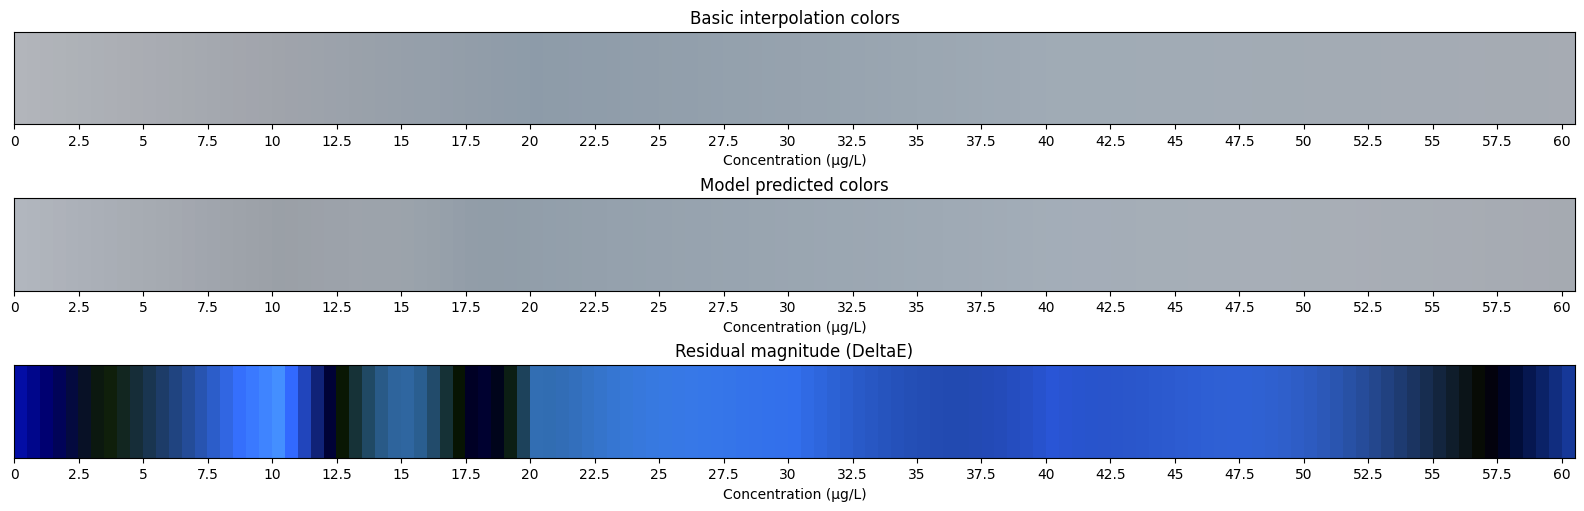

In [52]:
# Basic vs predicted color gradients plus residual (DeltaE) bar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB, XYZ_to_Lab
from colour import MSDS_CMFS, SDS_ILLUMINANTS

# Tunables
PRED_GRID_CSV = "/content/drive/MyDrive/ArsenicSTS/uvvis_pred_grid_raw.csv"
MEASURED_CSV  = "/content/drive/MyDrive/ArsenicSTS/UVVisData/0.30MB_AuNP_As.csv"
ABS_MULT      = 4.0
LABEL_EVERY   = 5

# Colour setup
cmfs       = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']

def spectra_to_rgb_and_lab(wavelengths, absorbance):
    T = 10 ** (-ABS_MULT * absorbance)
    sd = SpectralDistribution(dict(zip(wavelengths, T)))
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100.0
    rgb = np.clip(XYZ_to_sRGB(XYZ), 0, 1)
    Lab = XYZ_to_Lab(XYZ, illuminant=illuminant)
    return rgb, Lab

# Predicted grid
df_pred = pd.read_csv(PRED_GRID_CSV)
df_pred.columns = df_pred.columns.map(str).str.strip()
df_pred["Wavelength"] = pd.to_numeric(df_pred["Wavelength"], errors="coerce")
vis_pred = df_pred[(df_pred["Wavelength"] >= 380) & (df_pred["Wavelength"] <= 780)].copy()
wvl = vis_pred["Wavelength"].values.astype(float)
pred_pairs = sorted([(float(c), c) for c in df_pred.columns if c != "Wavelength"], key=lambda x: x[0])
grid_concs = np.array([p[0] for p in pred_pairs], dtype=float)
pred_cols  = [p[1] for p in pred_pairs]

# Basic interpolation on same grid
df_meas = pd.read_csv(MEASURED_CSV)
df_meas.columns = df_meas.columns.map(str).str.strip()
df_meas["Wavelength"] = pd.to_numeric(df_meas["Wavelength"], errors="coerce")
vis_meas = df_meas[(df_meas["Wavelength"] >= 380) & (df_meas["Wavelength"] <= 780)].copy()

conc_known = []
for c in vis_meas.columns:
    if c == "Wavelength":
        continue
    try:
        conc_known.append(float(c))
    except:
        pass
conc_known = np.array(sorted(conc_known), dtype=float)
known_cols = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_known]
A_known = np.stack([vis_meas[c].astype(float).values for c in known_cols], axis=1)  # [λ, K]

A_basic = np.vstack([
    np.interp(grid_concs, conc_known, A_known[i, :])
    for i in range(A_known.shape[0])
])  # [λ, N]

# Colors and Lab for both
rgb_basic, lab_basic, rgb_pred, lab_pred = [], [], [], []
for j, col in enumerate(pred_cols):
    A_p = vis_pred[col].astype(float).values
    A_b = A_basic[:, j]
    c_rgb, c_lab = spectra_to_rgb_and_lab(wvl, A_b)
    p_rgb, p_lab = spectra_to_rgb_and_lab(wvl, A_p)
    rgb_basic.append(c_rgb); lab_basic.append(c_lab)
    rgb_pred.append(p_rgb);  lab_pred.append(p_lab)

rgb_basic = np.array(rgb_basic)  # [N,3]
rgb_pred  = np.array(rgb_pred)   # [N,3]
lab_basic = np.array(lab_basic)  # [N,3]
lab_pred  = np.array(lab_pred)   # [N,3]

# Residual magnitude per concentration: CIE76 DeltaE
deltaE = np.linalg.norm(lab_pred - lab_basic, axis=1)  # [N]
p1, p99 = np.percentile(deltaE, [1, 99])
scale_min, scale_max = p1, max(p99, p1 + 1e-6)
deltaE_norm = np.clip((deltaE - scale_min) / (scale_max - scale_min), 0, 1)

# Build 1xN images for imshow
N = len(grid_concs)
img_basic = rgb_basic[np.newaxis, :, :]
img_pred  = rgb_pred[np.newaxis, :, :]
img_resid = deltaE_norm[np.newaxis, :]

fig, axes = plt.subplots(3, 1, figsize=(max(10, 0.13*N), 5), constrained_layout=True)

axes[0].imshow(img_basic, aspect='auto', extent=[0, N, 0, 1])
axes[0].set_title("Basic interpolation colors")
axes[0].set_yticks([])
axes[0].set_xticks(range(0, N, LABEL_EVERY))
axes[0].set_xticklabels([f"{grid_concs[i]:g}" for i in range(0, N, LABEL_EVERY)])
axes[0].set_xlabel("Concentration (µg/L)")

axes[1].imshow(img_pred, aspect='auto', extent=[0, N, 0, 1])
axes[1].set_title("Model predicted colors")
axes[1].set_yticks([])
axes[1].set_xticks(range(0, N, LABEL_EVERY))
axes[1].set_xticklabels([f"{grid_concs[i]:g}" for i in range(0, N, LABEL_EVERY)])
axes[1].set_xlabel("Concentration (µg/L)")

axes[2].imshow(img_resid, aspect='auto', extent=[0, N, 0, 1],
               cmap='gray', vmin=0, vmax=1)
axes[2].set_title("Residual magnitude (DeltaE)")
axes[2].set_yticks([])
axes[2].set_xticks(range(0, N, LABEL_EVERY))
axes[2].set_xticklabels([f"{grid_concs[i]:g}" for i in range(0, N, LABEL_EVERY)])
axes[2].set_xlabel("Concentration (µg/L)")

plt.show()


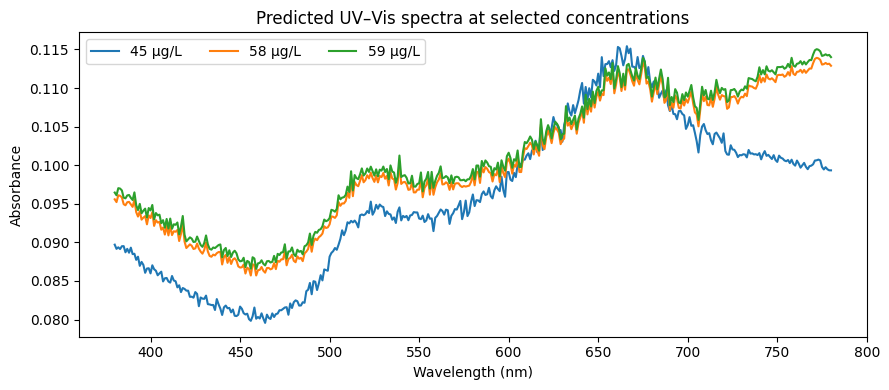

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tunables
GRID_CSV = "/content/drive/MyDrive/ArsenicSTS/uvvis_pred_grid_raw.csv"
CONCS_TO_PLOT = [45, 58, 59]  # µg/L
VISIBLE_ONLY = True  # set False to show full 200–800 nm

# Load grid (wide format: Wavelength, 0, 0.5, 1, ..., 60)
df = pd.read_csv(GRID_CSV)
df.columns = df.columns.map(str).str.strip()
df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")

# Visible filter
if VISIBLE_ONLY:
    df = df[(df["Wavelength"] >= 380) & (df["Wavelength"] <= 780)]

# Helper to match column names exactly as saved
def col_name(c):
    return str(int(c)) if float(c).is_integer() else str(c)

# Plot
plt.figure(figsize=(9, 4))
for c in CONCS_TO_PLOT:
    col = col_name(c)
    if col not in df.columns:
        print(f"Warning: concentration column '{col}' not found in {GRID_CSV}")
        continue
    plt.plot(df["Wavelength"].values, df[col].values, label=f"{c} µg/L")

plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Predicted UV–Vis spectra at selected concentrations")
plt.legend(ncol=3)
plt.tight_layout()
plt.show()

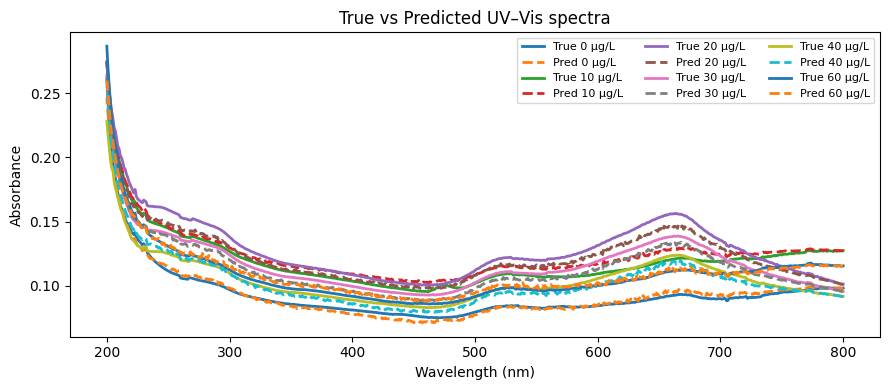

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Tunables
RAW_CSV = "/content/drive/MyDrive/ArsenicSTS/uvvis_predictions_raw.csv"
CONCS_TO_PLOT = [0, 10, 20, 30, 40, 60]  # µg/L
VISIBLE_ONLY = True

# Load and optionally restrict to visible range
df = pd.read_csv(RAW_CSV)
#if VISIBLE_ONLY:
    #df = df[(df["Wavelength"] >= 380) & (df["Wavelength"] <= 780)]

# Plot all chosen concentrations
plt.figure(figsize=(9, 4))
for c in CONCS_TO_PLOT:
    sub = df[df["Concentration"] == c]
    if sub.empty:
        print(f"Warning: no data for concentration {c}")
        continue
    wl = sub["Wavelength"].values
    A_true = sub["Absorbance_True"].values
    A_pred = sub["Absorbance_Pred"].values

    # True in solid line, predicted in dashed line
    plt.plot(wl, A_true, label=f"True {c} µg/L", lw=2)
    plt.plot(wl, A_pred, "--", label=f"Pred {c} µg/L", lw=2)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("True vs Predicted UV–Vis spectra")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()


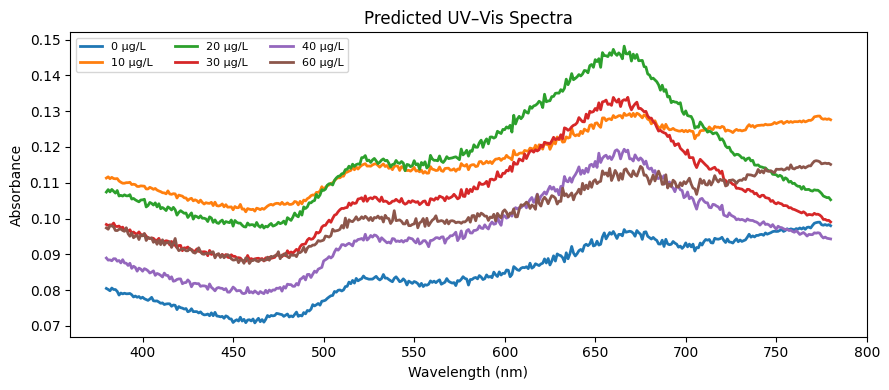

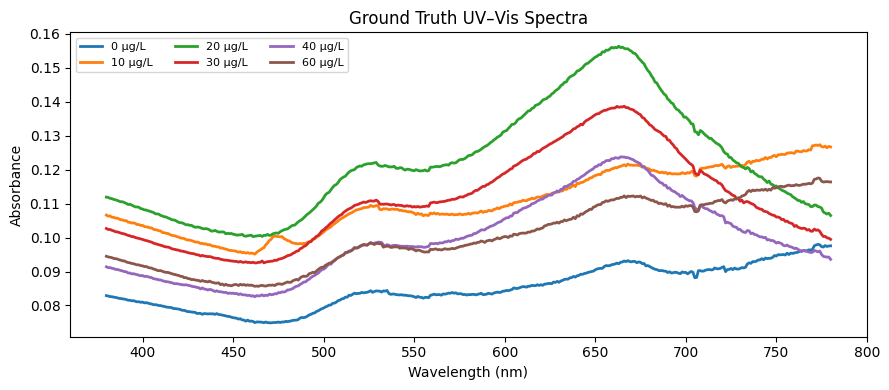

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Tunables
RAW_CSV = "/content/drive/MyDrive/ArsenicSTS/uvvis_predictions_raw.csv"
CONCS_TO_PLOT = [0, 10, 20, 30, 40, 60]  # µg/L
VISIBLE_ONLY = True

# Load and optionally restrict to visible range
df = pd.read_csv(RAW_CSV)
if VISIBLE_ONLY:
    df = df[(df["Wavelength"] >= 380) & (df["Wavelength"] <= 780)]

# --- Plot 1: Predicted spectra ---
plt.figure(figsize=(9, 4))
for c in CONCS_TO_PLOT:
    sub = df[df["Concentration"] == c]
    if sub.empty:
        print(f"Warning: no data for concentration {c}")
        continue
    wl = sub["Wavelength"].values
    A_pred = sub["Absorbance_Pred"].values
    plt.plot(wl, A_pred, label=f"{c} µg/L", lw=2)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Predicted UV–Vis Spectra")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

# --- Plot 2: Ground-truth spectra ---
plt.figure(figsize=(9, 4))
for c in CONCS_TO_PLOT:
    sub = df[df["Concentration"] == c]
    if sub.empty:
        continue
    wl = sub["Wavelength"].values
    A_true = sub["Absorbance_True"].values
    plt.plot(wl, A_true, label=f"{c} µg/L", lw=2)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Ground Truth UV–Vis Spectra")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()


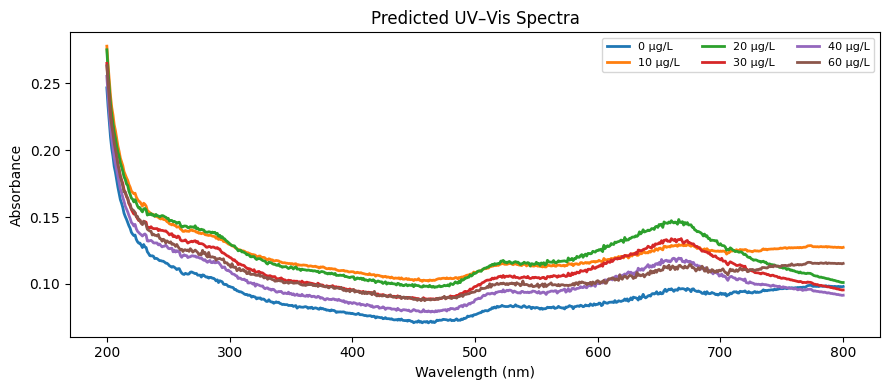

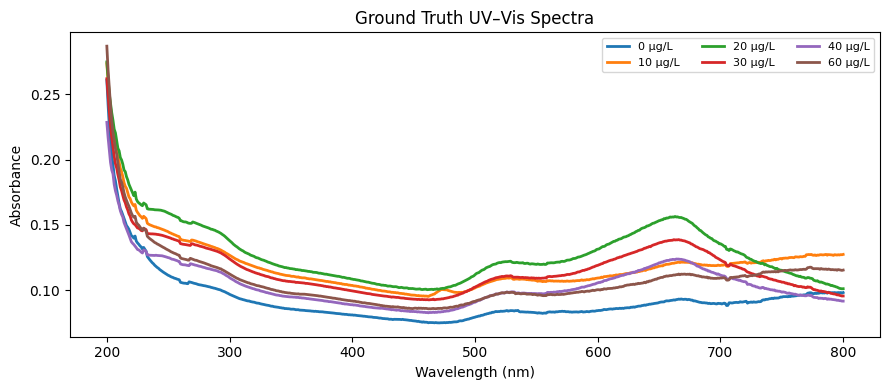

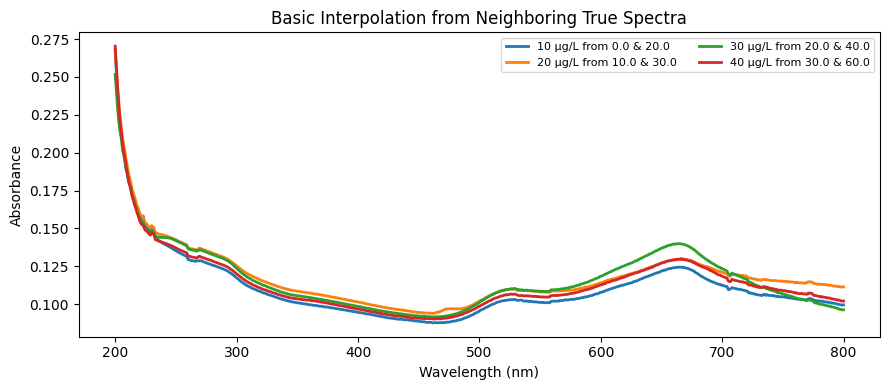

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tunables
RAW_CSV = "/content/drive/MyDrive/ArsenicSTS/uvvis_predictions_raw.csv"
CONCS_TO_PLOT = [0, 10, 20, 30, 40, 60]  # µg/L
VISIBLE_ONLY = True

# Load and optionally restrict to visible range
df = pd.read_csv(RAW_CSV)
#if VISIBLE_ONLY:
    #df = df[(df["Wavelength"] >= 380) & (df["Wavelength"] <= 780)]

# --- Plot 1: Predicted spectra ---
plt.figure(figsize=(9, 4))
for c in CONCS_TO_PLOT:
    sub = df[df["Concentration"] == c]
    if sub.empty:
        print(f"Warning: no data for concentration {c}")
        continue
    wl = sub["Wavelength"].values
    A_pred = sub["Absorbance_Pred"].values
    plt.plot(wl, A_pred, label=f"{c} µg/L", lw=2)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Predicted UV–Vis Spectra")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

# --- Plot 2: Ground-truth spectra ---
plt.figure(figsize=(9, 4))
for c in CONCS_TO_PLOT:
    sub = df[df["Concentration"] == c]
    if sub.empty:
        continue
    wl = sub["Wavelength"].values
    A_true = sub["Absorbance_True"].values
    plt.plot(wl, A_true, label=f"{c} µg/L", lw=2)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Ground Truth UV–Vis Spectra")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

# --- Plot 3: Simple neighbor interpolation (ground-truth only) ---
# For each interior concentration, linearly interpolate its spectrum from the nearest lower and higher
# ground-truth concentrations (e.g., 10 from 0 and 20, 20 from 10 and 30, etc.)
available_concs = np.array(sorted(df["Concentration"].unique()))
plt.figure(figsize=(9, 4))

for c in CONCS_TO_PLOT[1:-1]:  # exclude endpoints 0 and 60
    # find neighbors in the available set
    idx = np.where(available_concs == c)[0]
    if len(idx) == 0:
        print(f"Warning: {c} not found in data, skipping.")
        continue
    i = idx[0]
    if i == 0 or i == len(available_concs) - 1:
        # skip if no both-side neighbors
        continue
    c0, c1 = available_concs[i-1], available_concs[i+1]

    s0 = df[df["Concentration"] == c0].sort_values("Wavelength")
    s1 = df[df["Concentration"] == c1].sort_values("Wavelength")
    st = df[df["Concentration"] == c].sort_values("Wavelength")  # just to get wavelength grid

    wl = st["Wavelength"].values
    A0 = s0["Absorbance_True"].values
    A1 = s1["Absorbance_True"].values

    # linear interpolation weight
    w = (c - c0) / (c1 - c0 + 1e-12)
    A_lin = (1 - w) * A0 + w * A1

    plt.plot(wl, A_lin, label=f"{c} µg/L from {c0} & {c1}", lw=2)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Basic Interpolation from Neighboring True Spectra")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()
